# GEOCLIM Single Lithology Parameter Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle

from tqdm import tqdm_notebook

from netCDF4 import Dataset
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature

from scipy import stats
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

## Functions

In [2]:
def extract_basin_variables(param_nc):
    """
    Get data for each basin in the basin mask.
    
    Parameters
    ----------
    param_nc : netCDF dataset
        netCDF output from the parameter exploration routine.
    
    Returns
    -------
    basin_model_df : dataframe
        Contains the t(CaMgNaK)/yr/km2 for each basin.
        
    total_CO2_consumption : array
        Total CO2 consumption (mol/yr) for each run.
    """
    n_runs = len(param_nc.variables['parameterization'])
    n_basins = len(basin_data['basin'])
    
    # get area map - units: m2
    area_map = param_nc.variables['land_area'][:,:].data.copy()
    area_map[np.isnan(area_map)] = 0
    area_map[area_map > 1e30] = 0
    
    # storage arrays
    basin_model = np.zeros((n_runs, n_basins))
    total_CO2_consumption = np.zeros(n_runs)
    
    # loop over each parameter run
    for i in tqdm_notebook(range(n_runs), desc='run loop'):
        
        # get CO2 consumption map - units: mol(CaMg)/m2/yr
        weath_map = param_nc.variables['weathering'][i,:,:].data.copy()
        weath_map[np.isnan(weath_map)] = 0
        weath_map[weath_map > 1e30] = 0
        
        # convert CO2 consumption map from mol(CaMg)/m2/yr to mol(CaMg)/yr
        weath_total_map = weath_map * area_map
        
        # get total CO2 consumption
        total_CO2_consumption[i] = np.nansum(weath_total_map)         
        
        # loop over each basin
        for j in range(n_basins):
            
            # pull out the basin mask - units are in m2
            if basin_data['basin'][j] in basin_mask_1.variables.keys():
                this_basin_mask = basin_mask_1.variables[basin_data['basin'][j]][:,:].data.copy()
            elif basin_data['basin'][j] in basin_mask_2.variables.keys():
                this_basin_mask = basin_mask_2.variables[basin_data['basin'][j]][:,:].data.copy()
            else:
                print('!! WARNING !! {} not in the basin masks!'.format(basin_data['basin'][j]))
                break
                
            this_basin_mask[np.isnan(this_basin_mask)] = 0
            this_basin_mask[this_basin_mask < 0] = 0
                
            # sum and store - mol(CaMg)/yr/m2
            basin_model[i, j] = np.nansum(weath_map*this_basin_mask) / np.nansum(this_basin_mask)
            
    # store as a dataframe        
    basin_model_df = pd.DataFrame(columns=basin_data['basin'], data=basin_model)
    
    # convert from mol(CaMg)/yr/m2 to t(CaMgNaK)/yr/km2
    for i in range(n_basins):
        Gaillardet1999a_row = Gaillardet1999a_Table3[Gaillardet1999a_Table3['Basins']==basin_names[i]]
        if len(Gaillardet1999a_row.index)!=0:
            mol_kg = Gaillardet1999a_row['silicates_Ca+Mg_sil'].values[0]/\
                     Gaillardet1999a_row['silicates_Cation_sil'].values[0]
        else:
            mol_kg = 12.5
        basin_model_df[basin_data['basin'][i]] = ((basin_model_df[basin_data['basin'][i]]/mol_kg)/1000)*1e6
    
    return basin_model_df, total_CO2_consumption

In [3]:
def get_regression_coefficient(data, model):
    """
    Calculate the regression coefficient, as in Maffre et al. (2018) Appendix C.
    
    Parameters
    ----------
    data : array
        data values
        
    model : array
        model values
    
    Returns
    -------
    r2s : array
        regression coefficient
    """
    # convert to log
    model = np.log10(model.astype(np.float64))
    data = np.log10(data.astype(np.float64))
    
    # storage array
    r2s = np.zeros(np.shape(model)[0])
    
    for i in range(len(r2s)):
    
        # calculate the fraction
        numerator = np.sum((model[i,:] - data)**2)
        denominator = np.sum((data - np.mean(data))**2)
        
        # output r2
        r2s[i] = 1 - numerator/denominator
    
    return r2s

In [4]:
def get_params(param_nc):
    """
    Get the parameters out of the netCDF and into a pandas dataframe.
    
    Parameters
    ----------
    param_nc : netCDF dataset
        netCDF output from the parameter exploration routine.
        
    Returns
    -------
    params : dataframe
        parameters extracted from the netCDF output.
    """
    
    params_cols = ['Ea',
                   'T0',
                   'Kwest',
                   'kw',
                   'sigma',
                   'WSI']
    
    params = pd.DataFrame(columns=params_cols)
    
    for i in range(len(params_cols)):
        col_vals = param_nc.variables[params_cols[i]][:].data
        params[params_cols[i]] = col_vals
        
    params['krp'] = np.ones(len(params)) * np.float64(param_nc.variables['krp'][:].data)
    
    params['CaMg_1'] = param_nc.variables['CaMg'][:,0].data
    params['CaMg_2'] = param_nc.variables['CaMg'][:,1].data
    params['CaMg_3'] = param_nc.variables['CaMg'][:,2].data
    params['CaMg_4'] = param_nc.variables['CaMg'][:,3].data
    params['CaMg_5'] = param_nc.variables['CaMg'][:,4].data
    params['CaMg_6'] = param_nc.variables['CaMg'][:,5].data
    
    return params

In [5]:
def triple_scatter(X, Y, Z, X_label, Y_label, Z_label, **kwargs):
    """
    Create a scatter plot where the data points are colored by a third variable.
    
    Parameters
    ----------
    X : array-like
        Data for the x-axis.
        
    Y : array-like
        Data for the y-axis.
        
    Z : array-like
        Data for the color.
        
    X_label : string
        Label for the x-axis.
    
    Y_label : string
        Label for the y-axis.
        
    Z_label : string
        Label for the colorbar.
        
    kwargs : keyword arguments
        Passed to plt.scatter.
    """
    fig, ax = plt.subplots(figsize=(5,5))
    
    vmin = np.min(Z)
    vmax = np.max(Z)
    
    scatter = ax.scatter(X, Y, c=Z, vmin=vmin, vmax=vmax, **kwargs)
    ax.set_xlabel(X_label)
    ax.set_ylabel(Y_label)
    
    cbar_position = fig.add_axes([0.95,0.1,0.04,0.8])
    cbar = fig.colorbar(scatter, cax=cbar_position)
    cbar.ax.set_ylabel(Z_label, rotation=270, labelpad=20)
    
    plt.show(fig)

In [6]:
def log_cross_plot(model, data, source, r2, ax, legend=True, labels=True):
    """
    Cross plot basin model output vs data.
    
    Parameters
    ----------
    model : numpy array
        Model output (silicate Ca+Mg+Na+K [t/km$^{2}$/yr]).
        
    data : numpy array
        Data (silicate Ca+Mg+Na+K [t/km$^{2}$/yr]).
        
    source : list
        The source of each data point.
        
    r2 : float
        Pre-computed regression coefficient.
        
    ax : matplotlib axis
        To plot onto.
        
    legend : boolean
        If True, add a legend.
        
    labels : boolean
        If True, add axis labels.
    """
    unique_sources = ['Gaillardet et al. (1999)',
                      'HYBAM Amazon',
                      'HYBAM Pacific']

    # Ca + Mg + Na + K
    xlim = np.array([1e-2, 1e3])
    ylim = np.array([1e-2, 1e3])

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.plot(xlim, ylim, c='r', ls='--', zorder=-99, alpha=0.5)
    ax.plot(xlim, ylim*2, c='b', ls='--', zorder=-99, alpha=0.5)
    ax.plot(xlim, ylim*(1/2), c='b', ls='--', zorder=-99, alpha=0.5)
    ax.plot(xlim, ylim*5, c='c', ls='--', zorder=-99, alpha=0.5)
    ax.plot(xlim, ylim*(1/5), c='c', ls='--', zorder=-99, alpha=0.5)
    ax.plot(xlim, ylim*10, c='c', ls='--', zorder=-99, alpha=0.5)
    ax.plot(xlim, ylim*(1/10), c='c', ls='--', zorder=-99, alpha=0.5)

    for i in range(len(unique_sources)):
        source_inds = np.argwhere(source==unique_sources[i])
        source_inds = source_inds.flatten()
        ax.plot(data[source_inds], model[source_inds],
                'o', c='C'+str(i), label=unique_sources[i])

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_aspect('equal', adjustable='box')
    
    if labels:
        ax.set_xlabel('data\nsilicate Ca+Mg+Na+K [t/km$^{2}$/yr]')
        ax.set_ylabel('model\nsilicate Ca+Mg+Na+K [t/km$^{2}$/yr]')

    ax.text(0.2, 0.95, 'r$^2$ = {:.2f}'.format(r2), fontsize=14, fontweight='bold',
            horizontalalignment='center',verticalalignment='center',transform=ax.transAxes)
    
    if legend:
        ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

## Basin Data

Get the files:

In [7]:
drive_path = '/Users/yuempark/Documents/Berkeley/Research_GEOCLIM/Paleogeo_GEOCLIM/'

# watershed masks

##### FOR 180x360 #####
#basin_mask_1 = Dataset(drive_path+'river_database/G1999_basins_180_360.nc')
#basin_mask_2 = Dataset(drive_path+'river_database/amazon_basins_180_360_global.nc')

##### FOR 360x720 #####
basin_mask_1 = Dataset(drive_path+'river_database/G1999_basins_360_720.nc')
basin_mask_2 = Dataset(drive_path+'river_database/amazon_basins_360_720_global.nc')

In [8]:
# observed data
basin_data_nc = Dataset(drive_path+'weathering_basins/weathering_Gaillardet+HYBAM_2.nc')

Gaillardet1999a_Table3 = pd.read_csv(drive_path+'weathering_basins/Gaillardet1999a_Table3.csv')
Gaillardet1999a_Table3 = Gaillardet1999a_Table3[Gaillardet1999a_Table3['Basins']!='World average']

Extract the observed data for each basin:

In [9]:
# pull out the basin names
basin_names = []
for i in range(len(basin_data_nc.variables['basin'].ncattrs())):
    basin_names.append(getattr(basin_data_nc.variables['basin'], basin_data_nc.variables['basin'].ncattrs()[i]))
    
# create the dataframe
basin_data = pd.DataFrame({'basin':basin_names,
                           'area':basin_data_nc.variables['area'][:].data,
                           'discharge':basin_data_nc.variables['discharge'][:].data,
                           'CaMgNaK_sil':basin_data_nc.variables['cation_sil'][:].data})

# get rid of fill values
basin_data.loc[basin_data['area']>1e36, 'area'] = np.nan
basin_data.loc[basin_data['discharge']>1e36, 'discharge'] = np.nan
basin_data.loc[basin_data['CaMgNaK_sil']>1e36, 'CaMgNaK_sil'] = np.nan

# get rid of those basins without cation data
basin_data = basin_data[np.isfinite(basin_data['CaMgNaK_sil'])]

# get rid of the Don River and VGR (as per Maffre et al., 2018 Appendix B)
basin_data = basin_data[basin_data['basin']!='Don']
basin_data = basin_data[basin_data['basin']!='VGR']
basin_data.reset_index(drop=True, inplace=True)

# add Esmeraldas from HYBAM data .csv
basin_data.loc[basin_data.index.max()+1] = ['esmeraldas', 19000, 857e-9*60*60*24*365.25, (20.2/1e6)*19000]

# get the basin names again, before they get altered below
basin_names = basin_data['basin'].to_list()

# make it match the spelling in Gaillardet et al. (1999) Table 3
for i in range(len(basin_names)):
    basin_names[i] = basin_names[i].replace('Yenissei', 'Yenisei')
    basin_names[i] = basin_names[i].replace('Congo', 'Congo-Zaire')
    basin_names[i] = basin_names[i].replace('Huang He', 'Huanghe')
    basin_names[i] = basin_names[i].replace('Shatt el arab', 'Shatt el Arab')
    basin_names[i] = basin_names[i].replace('Yenissei', 'Yenisei')
    
# get silicate Ca+Mg (for HYBAM, use 12.5 mol/kg)
mean_mol_kg = 12.5
for i in range(len(basin_names)):
    Gaillardet1999a_row = Gaillardet1999a_Table3[Gaillardet1999a_Table3['Basins']==basin_names[i]]
    if len(Gaillardet1999a_row.index)!=0:
        basin_data.loc[i,'CaMg_sil'] = Gaillardet1999a_row['silicates_Ca+Mg_sil'].values[0]
    else:
        basin_data.loc[i,'CaMg_sil'] = (basin_data['CaMgNaK_sil'][i]*1e6*1e3 * mean_mol_kg) / 1e9

# change basin names to match the formatting (and typos) in the basin mask
for i in range(49):
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].lower()
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace('.', '')
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace(' ', '_')
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace('huang_he', 'huanghe')
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace('hong_he', 'honghe')
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace('congo-zaire', 'congo')
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace('murray_darling', 'murray')
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace('yenisei', 'yenissei')
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace('kuskokwin', 'kuskowin')
    
# convert units of CaMgNaK_sil from Mt/yr to t/yr
basin_data['CaMgNaK_sil'] = basin_data['CaMgNaK_sil'] * 1e6

# store the source of the data
for i in range(len(basin_data.index)):
    if i <= 48:
        basin_data.loc[i, 'source'] = 'Gaillardet et al. (1999)'
    elif i <= 75:
        basin_data.loc[i, 'source'] = 'HYBAM Amazon'
    else:
        basin_data.loc[i, 'source'] = 'HYBAM Pacific'
        
# normalize to area
basin_data['CaMg_sil_norm'] = basin_data['CaMg_sil'] / basin_data['area']
basin_data['CaMgNaK_sil_norm'] = basin_data['CaMgNaK_sil'] / basin_data['area']

print('units:')
print('')
print('area        = km2')
print('discharge   = km3/yr')
print('CaMgNaK_sil = t/yr Ca+Mg+Na+K')
print('CaMg_sil    = 1e9 mol/yr Ca+Mg')

basin_data

units:

area        = km2
discharge   = km3/yr
CaMgNaK_sil = t/yr Ca+Mg+Na+K
CaMg_sil    = 1e9 mol/yr Ca+Mg


,basin,area,discharge,CaMgNaK_sil,CaMg_sil,source,CaMg_sil_norm,CaMgNaK_sil_norm
0,amazon,6112000.0,6590.000000,1.320000e+07,128.000000,Gaillardet et al. (1999),0.000021,2.159686
1,changjiang,1808000.0,928.000000,2.500000e+06,29.000000,Gaillardet et al. (1999),0.000016,1.382743
2,mississippi,2980000.0,580.000000,5.100000e+06,60.000000,Gaillardet et al. (1999),0.000020,1.711409
3,irrawady,410000.0,486.000000,1.710000e+07,165.000000,Gaillardet et al. (1999),0.000402,41.707318
4,ganges,1630000.0,1003.000000,9.800000e+06,130.000000,Gaillardet et al. (1999),0.000080,6.012270
5,yenissei,2590000.0,620.000000,3.200000e+06,30.000000,Gaillardet et al. (1999),0.000012,1.235521
6,mackenzie,1787000.0,308.000000,1.600000e+06,19.000000,Gaillardet et al. (1999),0.000011,0.895355
7,st_lawrence,1020000.0,337.000000,8.000000e+05,9.000000,Gaillardet et al. (1999),0.000009,0.784314
8,lena,2490000.0,525.000000,1.700000e+06,19.000000,Gaillardet et al. (1999),0.000008,0.682731
9,xijiang,437000.0,363.000000,7.000000e+05,9.000000,Gaillardet et al. (1999),0.000021,1.601831


Area sanity check:

In [10]:
basin_mask_areas = np.zeros(len(basin_data))

for i in range(len(basin_data)):
    # pull out the basin mask
    if basin_data['basin'][i] in basin_mask_1.variables.keys():
        this_basin_mask = basin_mask_1.variables[basin_data['basin'][i]][:,:].data.copy()
    elif basin_data['basin'][i] in basin_mask_2.variables.keys():
        this_basin_mask = basin_mask_2.variables[basin_data['basin'][i]][:,:].data.copy()
    else:
        print('!! WARNING !! {} not in the basin masks!'.format(basin_data['basin'][j]))
        break
        
    this_basin_mask[np.isnan(this_basin_mask)] = 0
    this_basin_mask[this_basin_mask < 0] = 0
    
    basin_mask_areas[i] = np.nansum(this_basin_mask)

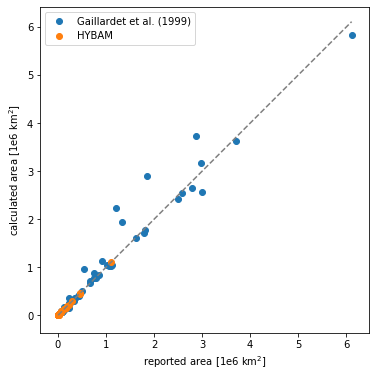

In [11]:
fig, ax = plt.subplots(figsize=(6,6))

ref_line = np.array([np.min(basin_data['area']/1e6),
                     np.max(basin_data['area']/1e6)])

ax.plot(ref_line, ref_line, ls='--', c='C7')

ax.scatter(basin_data[basin_data['source']=='Gaillardet et al. (1999)']['area']/1e6,
           basin_mask_areas[basin_data['source']=='Gaillardet et al. (1999)']/1e6/1e6,
           c='C0', label='Gaillardet et al. (1999)')

ax.scatter(basin_data[basin_data['source']!='Gaillardet et al. (1999)']['area']/1e6,
           basin_mask_areas[basin_data['source']!='Gaillardet et al. (1999)']/1e6/1e6,
           c='C1', label='HYBAM')

ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('reported area [1e6 km$^{2}$]')
ax.set_ylabel('calculated area [1e6 km$^{2}$]')
ax.legend()

plt.show(fig)

## GEOCLIM Output

A refresh switch, so we can read in old calculations for analysis purposes:

In [12]:
refresh_1 = False

# choose 'combined' if you would like to concatenate all the parameter sets with varying krp
# but must have run refresh_1 on each parameter set individually beforehand
param_set = 'combined'

In [13]:
# perform the full watershed calculations
if refresh_1:
    
    # read in the file
    #path = '/Volumes/GEOCLIM/parameter-exploration/'
    path = '/Users/yuempark/Downloads/parameter-exploration/'
    param_nc = Dataset(path+'single_lithology_'+param_set+'.nc')
    
    # get the parameters of interest out of the netCDF
    params = get_params(param_nc)
    params.to_csv('../Output/single_lithology/params_'+param_set+'.csv', index=False)
    
    # get the silicate weathering for each basin for each run, in t/km2/yr of Ca+Mg+Na+K:
    basin_model, total_CO2_consumption = extract_basin_variables(param_nc)
    basin_model.to_csv('../Output/single_lithology/basin_model_'+param_set+'.csv', index=False)
    np.savetxt('../Output/single_lithology/total_CO2_consumption_'+param_set+'.csv', total_CO2_consumption, delimiter=',')

# concatenate the 30min parameter sets with varying krp
elif param_set == 'combined':
    
    # set refresh_1 to be False
    refresh_1 = False
    
    # concatenate
    param_set_list = ['krp_1_2_e-3','krp_2_0_e-3','krp_3_0_e-3','krp_5_0_e-3','krp_1_0_e-2','krp_1_5_e-2']
    
    params = pd.read_csv('../Output/single_lithology/params_'+param_set_list[0]+'.csv')
    basin_model = pd.read_csv('../Output/single_lithology/basin_model_'+param_set_list[0]+'.csv')
    total_CO2_consumption = np.loadtxt('../Output/single_lithology/total_CO2_consumption_'+param_set_list[0]+'.csv', delimiter=',')
    
    for i in range(1,len(param_set_list)):
        params_subset = pd.read_csv('../Output/single_lithology/params_'+param_set_list[i]+'.csv')
        basin_model_subset = pd.read_csv('../Output/single_lithology/basin_model_'+param_set_list[i]+'.csv')
        total_CO2_consumption_subset = np.loadtxt('../Output/single_lithology/total_CO2_consumption_'+param_set_list[i]+'.csv',
                                                  delimiter=',')
        
        params = pd.concat([params,params_subset], ignore_index=True)
        basin_model = pd.concat([basin_model,basin_model_subset], ignore_index=True)
        total_CO2_consumption = np.append(total_CO2_consumption, total_CO2_consumption_subset)
    
# just read in a single parameter set
else:
    
    # read in the previous calculations
    params = pd.read_csv('../Output/single_lithology/params_'+param_set+'.csv')
    basin_model = pd.read_csv('../Output/single_lithology/basin_model_'+param_set+'.csv')
    total_CO2_consumption = np.loadtxt('../Output/single_lithology/total_CO2_consumption_'+param_set+'.csv', delimiter=',')
    
run_ID = np.arange(len(total_CO2_consumption))

In [14]:
print('number of runs: {}'.format(len(params)))

number of runs: 21600


In [15]:
basin_model.head()

,amazon,changjiang,mississippi,irrawady,ganges,yenissei,mackenzie,st_lawrence,lena,xijiang,ob,parana,mekong,congo,rhine,yukon,orinoco,magdalena,columbia,indus,nelson,n_dvina,amur,huanghe,rhone,shatt_el_arab,honghe,po,fly,tocantins,dnepr,sepik,nile,narmada,murray,purari,fraser,kolima,krishna,pechora,niger,uruguay,kuskowin,cauveri,zambese,khatanga,seine,kikori,limpopo,ABA,ALT,ATA,BEL,BOR,CAI,CAR,CHA,DJI,FOR,GUA,ITA,JHE,LAB,MAN,MIR,NLO,NRO,NYO,PCH,PSI,PUN,PVI,RUR,SAN,SEB,SER,canete,ocona,santa,tumbes,esmeraldas
0,0.000410,0.000095,0.000018,0.000577,0.00015,0.000004,0.000002,0.000026,5.891066e-07,0.000223,0.000004,0.000030,0.000224,0.000099,0.000056,0.000002,0.000393,0.000382,0.000020,0.000014,0.000002,0.000010,0.000003,0.000003,0.000048,0.000010,0.000215,0.000080,0.000380,0.000221,0.000004,0.000491,0.000008,0.000103,0.000003,0.000653,0.000024,2.489319e-07,0.000154,0.000007,0.000038,0.00006,0.000008,0.000219,0.000009,0.000002,0.000032,0.001149,0.000010,0.000017,0.000306,0.000193,0.000680,0.000184,0.000489,0.000278,0.000327,0.000160,0.001174,0.000204,0.000320,0.000523,0.000290,0.000431,0.000171,0.000589,0.000885,0.000568,0.000155,0.000088,0.000125,0.000078,0.000097,0.000132,0.000823,0.000520,0.000012,0.000011,0.000018,0.000097,0.000175
1,0.000546,0.000127,0.000024,0.000769,0.00020,0.000005,0.000003,0.000035,7.854755e-07,0.000297,0.000005,0.000040,0.000298,0.000133,0.000074,0.000003,0.000524,0.000509,0.000026,0.000019,0.000003,0.000013,0.000004,0.000003,0.000064,0.000014,0.000287,0.000106,0.000506,0.000295,0.000005,0.000655,0.000011,0.000137,0.000004,0.000871,0.000032,3.319092e-07,0.000205,0.000009,0.000050,0.00008,0.000010,0.000293,0.000012,0.000002,0.000043,0.001532,0.000013,0.000023,0.000408,0.000257,0.000907,0.000245,0.000651,0.000371,0.000435,0.000213,0.001566,0.000272,0.000427,0.000697,0.000387,0.000575,0.000228,0.000785,0.001180,0.000758,0.000206,0.000118,0.000167,0.000104,0.000129,0.000176,0.001097,0.000693,0.000016,0.000015,0.000024,0.000129,0.000233
2,0.000683,0.000158,0.000030,0.000961,0.00025,0.000006,0.000004,0.000044,9.818444e-07,0.000371,0.000007,0.000051,0.000373,0.000166,0.000093,0.000004,0.000654,0.000636,0.000033,0.000024,0.000004,0.000016,0.000005,0.000004,0.000080,0.000017,0.000358,0.000133,0.000633,0.000369,0.000007,0.000819,0.000014,0.000171,0.000005,0.001088,0.000041,4.148864e-07,0.000256,0.000012,0.000063,0.00010,0.000013,0.000366,0.000015,0.000003,0.000054,0.001914,0.000017,0.000029,0.000510,0.000321,0.001133,0.000307,0.000814,0.000464,0.000544,0.000267,0.001957,0.000340,0.000533,0.000871,0.000484,0.000719,0.000286,0.000982,0.001475,0.000947,0.000258,0.000147,0.000208,0.000130,0.000161,0.000220,0.001371,0.000866,0.000020,0.000018,0.000030,0.000161,0.000291
3,0.000819,0.000190,0.000036,0.001153,0.00030,0.000007,0.000005,0.000053,1.178213e-06,0.000446,0.000008,0.000061,0.000448,0.000199,0.000111,0.000005,0.000785,0.000763,0.000039,0.000029,0.000005,0.000020,0.000006,0.000005,0.000097,0.000021,0.000430,0.000159,0.000760,0.000443,0.000008,0.000983,0.000016,0.000205,0.000006,0.001306,0.000049,4.978637e-07,0.000307,0.000014,0.000075,0.00012,0.000015,0.000439,0.000018,0.000003,0.000065,0.002297,0.000020,0.000035,0.000612,0.000386,0.001360,0.000368,0.000977,0.000557,0.000653,0.000320,0.002349,0.000409,0.000640,0.001045,0.000581,0.000862,0.000343,0.001178,0.001770,0.001137,0.000310,0.000176,0.000250,0.000156,0.000193,0.000264,0.001645,0.001039,0.000024,0.000022,0.000036,0.000193,0.000349
4,0.000956,0.000221,0.000042,0.001346,0.00035,0.000009,0.000006,0.000061,1.374582e-06,0.000520,0.000009,0.000071,0.000522,0.000232,0.000130,0.000005,0.000916,0.000891,0.000046,0.000033,0.000005,0.000023,0.000006,0.000006,0.000113,0.000024,0.000502,0.000186,0.000886,0.000517,0.000009,0.001147,0.000019,0.000239,0.000007,0.001524,0.000057,5.808411e-07,0.000358,0.000016,0.000088,0.00014,0.000018,0.000512,0.000021,0.000004,0.000075,0.002680,0.000023,0.000041,0.000714,0.000450,0.001586,0.000429,0.001140,0.000649,0.000762,0.000373,0.002740

In [16]:
basin_model.tail()

,amazon,changjiang,mississippi,irrawady,ganges,yenissei,mackenzie,st_lawrence,lena,xijiang,ob,parana,mekong,congo,rhine,yukon,orinoco,magdalena,columbia,indus,nelson,n_dvina,amur,huanghe,rhone,shatt_el_arab,honghe,po,fly,tocantins,dnepr,sepik,nile,narmada,murray,purari,fraser,kolima,krishna,pechora,niger,uruguay,kuskowin,cauveri,zambese,khatanga,seine,kikori,limpopo,ABA,ALT,ATA,BEL,BOR,CAI,CAR,CHA,DJI,FOR,GUA,ITA,JHE,LAB,MAN,MIR,NLO,NRO,NYO,PCH,PSI,PUN,PVI,RUR,SAN,SEB,SER,canete,ocona,santa,tumbes,esmeraldas
21595,12.886780,33.788969,3.047938,54.795145,31.381402,16.453942,10.437413,7.103163,13.899285,25.911500,5.488236,2.846894,24.600287,4.994880,16.762040,16.994856,16.150636,40.762382,21.718739,30.157102,2.195582,2.228676,6.361472,6.124842,40.722272,6.674210,50.342881,70.181148,20.394921,7.016738,1.004968,30.257346,2.019339,5.087302,1.284200,49.872147,41.561227,19.093347,5.148158,3.598432,2.259595,3.464045,11.289529,11.635117,1.987635,12.236418,5.915022,57.802320,2.102023,21.178436,6.608168,53.338022,4.992066,55.885153,15.285945,3.792793,61.189294,46.859889,47.740951,4.330680,6.308265,17.116709,2.859508,4.411955,17.072830,79.029989,6.132013,3.911493,5.711647,6.132829,43.197975,29.478104,36.741192,55.448341,85.297899,6.142539,52.864041,36.524048,60.783768,31.817853,33.665524
21596,16.108476,42.236208,3.809922,68.493933,39.226752,20.567427,13.046765,8.878954,17.374109,32.389373,6.860295,3.558617,30.750363,6.243599,20.952550,21.243568,20.188294,50.952984,27.148424,37.696379,2.744478,2.785845,7.951840,7.656053,50.902835,8.342761,62.928594,87.726433,25.493655,8.770923,1.256210,37.821683,2.524175,6.359127,1.605250,62.340184,51.951537,23.866686,6.435197,4.498040,2.824494,4.330057,14.111912,14.543896,2.484543,15.295521,7.393776,72.252897,2.627529,26.473041,8.260210,66.672530,6.240083,69.856439,19.107429,4.740992,76.486607,58.574867,59.676189,5.413349,7.885330,21.395886,3.574385,5.514944,21.341038,98.787479,7.665015,4.889366,7.139559,7.666036,53.997459,36.847630,45.926490,69.310427,106.622381,7.678174,66.080046,45.655065,75.979700,39.772317,42.081904
21597,19.330170,50.683453,4.571906,82.192715,47.072097,24.680915,15.656117,10.654745,20.848928,38.867246,8.232354,4.270341,36.900434,7.492319,25.143061,25.492282,24.225953,61.143577,32.578108,45.235649,3.293372,3.343013,9.542209,9.187264,61.083406,10.011314,75.514308,105.271728,30.592386,10.525107,1.507452,45.386020,3.029009,7.630953,1.926301,74.808218,62.341838,28.640023,7.722237,5.397648,3.389393,5.196068,16.934292,17.452675,2.981452,18.354627,8.872532,86.703479,3.153034,31.767652,9.912252,80.007029,7.488099,83.827734,22.928915,5.689191,91.783943,70.289831,71.611428,6.496019,9.462397,25.675061,4.289263,6.617932,25.609243,118.544998,9.198018,5.867240,8.567472,9.199244,64.796963,44.217157,55.111785,83.172512,127.946854,9.213809,79.296060,54.786077,91.175652,47.726779,50.498281
21598,22.551868,59.130695,5.333891,95.891509,54.917451,28.794400,18.265471,12.430534,24.323753,45.345122,9.604413,4.982064,43.050502,8.741038,29.333571,29.740998,28.263613,71.334175,38.007793,52.774926,3.842268,3.900183,11.132576,10.718475,71.263973,11.679866,88.100027,122.817002,35.691114,12.279291,1.758694,52.950356,3.533844,8.902778,2.247351,87.276252,72.732148,33.413357,9.009276,6.297256,3.954292,6.062079,19.756675,20.361455,3.478361,21.413729,10.351287,101.154046,3.678540,37.062259,11.564293,93.341541,8.736116,97.799025,26.750402,6.637389,107.081261,82.004814,83.546677,7.578689,11.039463,29.954238,5.004140,7.720922,29.877453,138.302469,10.731021,6.845112,9.995383,10.732449,75.596461,51.586676,64.297090,97.034588,149.271317,10.749443,92.512074,63.917084,106.371593,55.681248,58.914666
21599,25.773560,67.577938,6.095875,109.590291,62.762804,32.907883,20.874827,14.206326,27.798570,51.822999,10.976472,5.693787,49.200575,9.989760,33.524079,33.989712,32.301273,81.524764,43.437478,60.314204,4.391164,4.457351,12.722945,12.249684,81.444544,13.348419,100.685761,140.362297,40.789842,14.033476,2.009936,60.514693,4.038678,10

Are there any basins where the weathering rate is 0?

In [17]:
basin_model.columns[np.unique(np.where(basin_model.values==0)[1])]

Index([], dtype='object')

## Model-Data Comparison

Do the regression:

In [18]:
r2s = get_regression_coefficient(basin_data['CaMgNaK_sil_norm'], basin_model.values)

Plot against total CO$_{2}$ consumption:

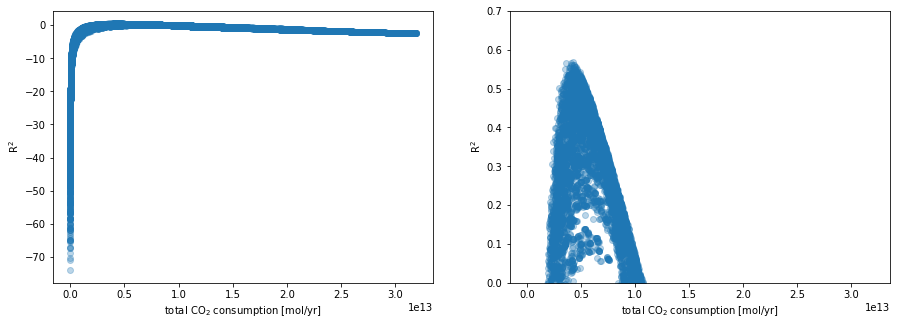

In [19]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].scatter(total_CO2_consumption, r2s, alpha=0.3)
ax[1].scatter(total_CO2_consumption, r2s, alpha=0.3)
ax[1].set_ylim(0,0.7)

ax[0].set_xlabel('total CO$_{2}$ consumption [mol/yr]')
ax[0].set_ylabel('R$^{2}$')

ax[1].set_xlabel('total CO$_{2}$ consumption [mol/yr]')
ax[1].set_ylabel('R$^{2}$')

plt.show(fig)

Plot against WSI (weathering saturation index):

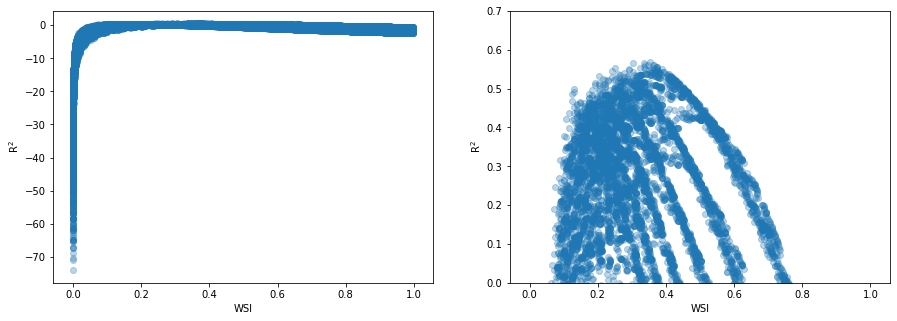

In [20]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].scatter(params['WSI'], r2s, alpha=0.3)
ax[1].scatter(params['WSI'], r2s, alpha=0.3)
ax[1].set_ylim(0,.7)

ax[0].set_xlabel('WSI')
ax[0].set_ylabel('R$^{2}$')

ax[1].set_xlabel('WSI')
ax[1].set_ylabel('R$^{2}$')

plt.show(fig)

The best perfoming run:

In [21]:
best_ind = np.argwhere(r2s == np.max(r2s))

best_Kwest = params['Kwest'][best_ind[0][0]]
best_kw = params['kw'][best_ind[0][0]]
best_sigma = params['sigma'][best_ind[0][0]]
best_CaMg_1 = params['CaMg_1'][best_ind[0][0]]
best_CaMg_6 = params['CaMg_6'][best_ind[0][0]]
best_krp = params['krp'][best_ind[0][0]]
best_total_CO2_consumption = total_CO2_consumption[best_ind[0][0]]
best_WSI = params['WSI'][best_ind[0][0]]

print('R^2                   = {:.3f}'.format(np.max(r2s)))
print('Kwest                 = {}'.format(best_Kwest))
print('kw                    = {}'.format(best_kw))
print('sigma                 = {}'.format(best_sigma))
print('CaMg_1                = {}'.format(best_CaMg_1))
print('CaMg_6                = {}'.format(best_CaMg_6))
print('krp                   = {}'.format(best_krp))
print('total_CO2_consumption = {}'.format(best_total_CO2_consumption))
print('WSI                   = {}'.format(best_WSI))

R^2                   = 0.569
Kwest                 = 5e-05
kw                    = 1.0
sigma                 = -0.1
CaMg_1                = 1500.0
CaMg_6                = 1000.0
krp                   = 0.014999999664723871
total_CO2_consumption = 4237073317888.0
WSI                   = 0.35306653


/Users/yuempark/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


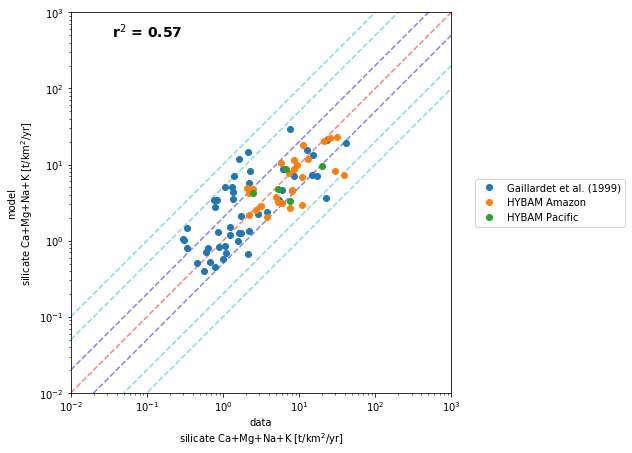

In [22]:
fig, ax = plt.subplots(figsize=(7,7))

log_cross_plot(basin_model.loc[best_ind[0][0]],
               basin_data['CaMgNaK_sil_norm'],
               basin_data['source'],
               np.max(r2s),
               ax,
               legend=True, labels=True)
    
plt.show(fig)

Filter out the runs that have unreasonable total CO$_{2}$ consumption:

In [23]:
min_thresh_CO2 = 1e12
max_thresh_CO2 = 1e13

drop_inds = np.argwhere((total_CO2_consumption>max_thresh_CO2) & (total_CO2_consumption<min_thresh_CO2)).flatten()

filt_basin_model = basin_model.copy()
filt_basin_model.drop(drop_inds, inplace=True)
filt_basin_model.reset_index(inplace=True, drop=True)

filt_params = params.copy()
filt_params.drop(drop_inds, inplace=True)
filt_params.reset_index(inplace=True, drop=True)

filt_total_CO2_consumption = np.delete(total_CO2_consumption, drop_inds)

filt_r2s = np.delete(r2s, drop_inds)

filt_run_ID = np.delete(run_ID, drop_inds)

Remove runs that have low R$^{2}$:

In [24]:
r2_95_percentile = np.percentile(r2s, 95)
print('95th percentile of r^2 = {:.2f}'.format(r2_95_percentile))

95th percentile of r^2 = 0.43


In [25]:
drop_inds = np.argwhere(filt_r2s<=0.4).flatten()

best_filt_basin_model = filt_basin_model.copy()
best_filt_basin_model.drop(drop_inds, inplace=True)
best_filt_basin_model.reset_index(inplace=True, drop=True)

best_filt_params = filt_params.copy()
best_filt_params.drop(drop_inds, inplace=True)
best_filt_params.reset_index(inplace=True, drop=True)

best_filt_total_CO2_consumption = np.delete(filt_total_CO2_consumption, drop_inds)

best_filt_r2s = np.delete(filt_r2s, drop_inds)

best_filt_run_ID = np.delete(filt_run_ID, drop_inds)

In [26]:
print('number of remaining runs = {}'.format(len(best_filt_r2s)))

number of remaining runs = 1461


Gerlach (2011) estimates global CO$_{2}$ consumption:

* all estimates = 0.285 ± 0.155 Gt/y (0.13-0.44)
* preferred estimates = 0.205 ± 0.055 Gt/y (0.15-0.26)

> Gerlach, T. (2011), Volcanic versus anthropogenic carbon dioxide, Eos Trans. AGU, 92(24), 201–202, doi:10.1029/2011EO240001

Lee et al. (2019) estimates endogenic C fluxes:

* 0.071-0.393 Gt/y

> ADD LEE REFERENCE HERE

In [27]:
# Gt/y of CO2
Gerlach_all = np.array([0.13, 0.44])
Gerlach_preferred = np.array([0.15, 0.26])

# convert to mol/yr
FW = 44.01
Gerlach_all = (Gerlach_all * 1e9 * 1e6) / FW
Gerlach_preferred = (Gerlach_preferred * 1e9 * 1e6) / FW

print(Gerlach_all)
print(Gerlach_preferred)

[2.95387412e+12 9.99772779e+12]
[3.40831629e+12 5.90774824e+12]


In [28]:
# Gt/y of C
Lee_all = np.array([0.071, 0.393])

# convert to mol/yr
FW = 12.01
Lee_all = (Lee_all * 1e9 * 1e6) / FW

print(Lee_all)

[5.91174022e+12 3.27227311e+13]


CO$_{2}$ consumption vs. R$^{2}$:

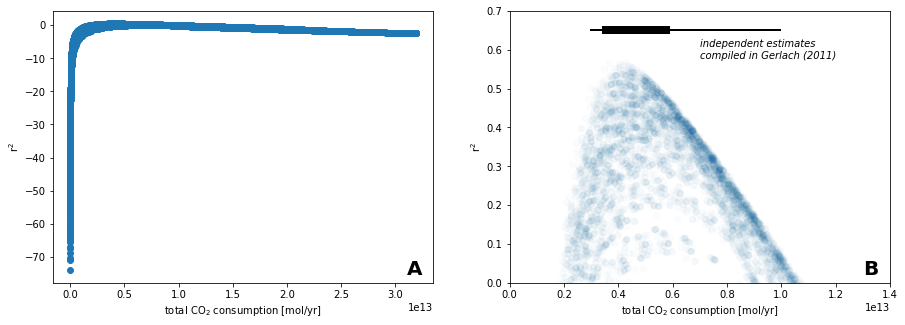

In [29]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].scatter(total_CO2_consumption, r2s, c='C0')

ax[0].set_xlabel('total CO$_{2}$ consumption [mol/yr]')
ax[0].set_ylabel('r$^{2}$')

ax[1].scatter(total_CO2_consumption, r2s, alpha=0.02, c='C0')
ax[1].set_ylim(0,0.7)
ax[1].set_xlim(0,1.4e13)

ax[1].hlines(y=0.65, xmin=Gerlach_all[0], xmax=Gerlach_all[1], color='k', lw=2)
ax[1].hlines(y=0.65, xmin=Gerlach_preferred[0], xmax=Gerlach_preferred[1], color='k', lw=8)
ax[1].text(0.7e13, 0.6, 'independent estimates\ncompiled in Gerlach (2011)', style='italic', fontsize=10,
           horizontalalignment='left', verticalalignment='center')

ax[1].set_xlabel('total CO$_{2}$ consumption [mol/yr]')
ax[1].set_ylabel('r$^{2}$')

ax[0].text(0.95, 0.05, 'A', fontweight='bold', fontsize=20,
           horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
ax[1].text(0.95, 0.05, 'B', fontweight='bold', fontsize=20,
           horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)

plt.show(fig)

In [30]:
print('CO2 consumption of good fits :')
print('max  = {:.1f} e12'.format(np.max(best_filt_total_CO2_consumption/1e12)))
print('min  = {:.1f} e12'.format(np.min(best_filt_total_CO2_consumption/1e12)))
print('mean = {:.1f} e12'.format(np.mean(best_filt_total_CO2_consumption/1e12)))
print('std  = {:.1f} e12'.format(np.std(best_filt_total_CO2_consumption/1e12)))

CO2 consumption of good fits :
max  = 6.7 e12
min  = 2.8 e12
mean = 5.0 e12
std  = 0.9 e12


Make histograms:

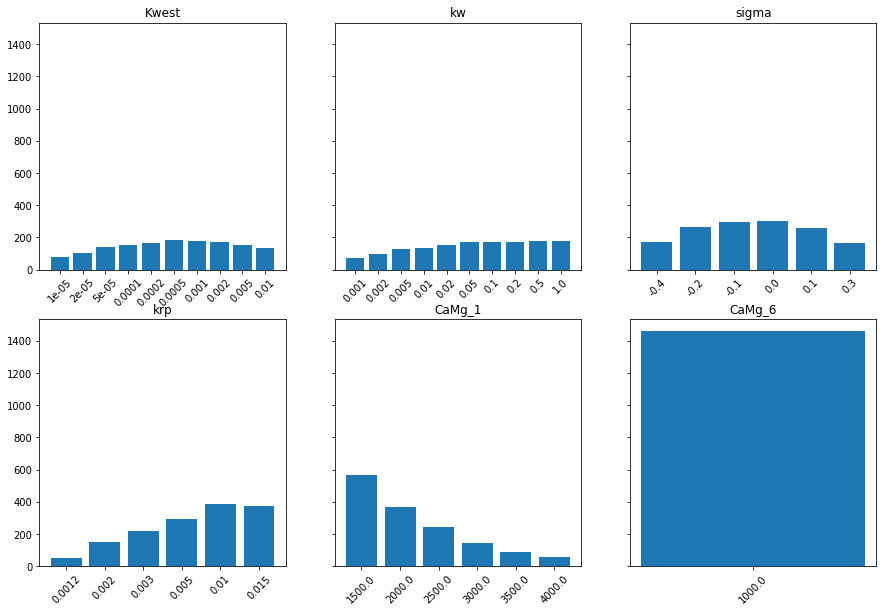

In [31]:
changing_params = ['Kwest','kw','sigma','krp','CaMg_1','CaMg_6']

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10), sharey=True)

ax = ax.flatten()

for i in range(len(changing_params)):
    unique_vals = np.array(best_filt_params[changing_params[i]].unique())
    unique_vals = np.sort(unique_vals)
    
    x_index = np.arange(len(unique_vals))
    y_vals = np.zeros(len(unique_vals))
    
    for j in range(len(unique_vals)):
        y_vals[j] = len(best_filt_params[best_filt_params[changing_params[i]]==unique_vals[j]])
    
    ax[i].bar(x_index,y_vals)
    
    ax[i].set_xticks(x_index)
    ax[i].set_xticklabels(np.round(unique_vals,7), rotation=45)
    
    ax[i].set_title(changing_params[i])

plt.show(fig)

## PCA

In [32]:
# get a dataframe with just the changing parameters
stat_cols = ['Kwest','kw','sigma','krp','CaMg_1','CaMg_6']
stat_df = best_filt_params[stat_cols].copy()

# standardize
scaler = StandardScaler()
stat_df = scaler.fit_transform(stat_df)
stat_df = pd.DataFrame(data=stat_df, columns=stat_cols)

# PCA
pca = PCA()
PCA_Y = pca.fit_transform(stat_df)

Make a variety of plots to assess the results of the PCA:

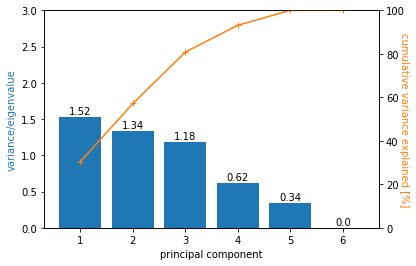

In [33]:
fig, ax = plt.subplots()

rects = ax.bar(np.arange(len(pca.explained_variance_))+1, pca.explained_variance_, color='C0')
ax.set_ylabel('variance/eigenvalue', color='C0')
ax.set_xlabel('principal component')
ax.set_ylim(0,3)

twinax = ax.twinx()
twinax.plot(np.arange(len(pca.explained_variance_ratio_))+1,
            np.cumsum(pca.explained_variance_ratio_)*100, '-+', color='C1')
twinax.set_ylim(0,100)
twinax.set_ylabel('cumulative variance explained [%]', rotation=270, color='C1')

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        if height>=0:
            ax.text(rect.get_x() + rect.get_width()/2, height+0.08,
                    np.round(height,2),
                    ha='center', va='center')
        else:
            ax.text(rect.get_x() + rect.get_width()/2, height-0.08,
                    np.round(height,2),
                    ha='center', va='center')
            
autolabel(rects)

plt.show(fig)

In [34]:
N = len(stat_cols)
for i in range(N):
    print('PC' + str(i+1) + ': ' + str(np.round(pca.explained_variance_ratio_[i]*100,1)) + '%')

PC1: 30.5%
PC2: 26.7%
PC3: 23.6%
PC4: 12.3%
PC5: 6.8%
PC6: 0.0%


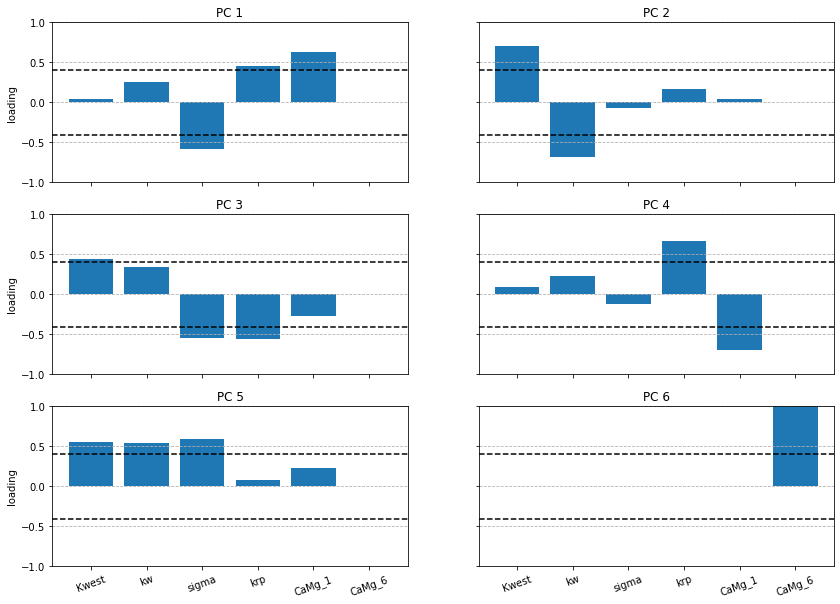

In [35]:
ind = np.arange(N)

component_names = []
for i in range(len(stat_cols)):
    component_names.append('PC ' + str(i+1))

eigenvectors = pd.DataFrame(pca.components_.T, columns=component_names, index=stat_cols)

cutoff = np.sqrt(1/len(stat_cols))

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(14,10), sharey=True)

ax = ax.flatten()

for i in range(N):
    ax[i].bar(ind, eigenvectors['PC ' + str(i+1)], color='C0')
    ax[i].set_ylim(-1,1)
    ax[i].yaxis.grid(ls='--')
    ax[i].axhline(cutoff, ls='--', c='k')
    ax[i].axhline(-cutoff, ls='--', c='k')
    ax[i].set_title('PC ' + str(i+1))
    ax[i].set_xticklabels([])
    
ax[4].set_xticks(ind)
ax[4].set_xticklabels(stat_cols, rotation=20)
ax[5].set_xticks(ind)
ax[5].set_xticklabels(stat_cols, rotation=20)

ax[0].set_ylabel('loading')
ax[2].set_ylabel('loading')
ax[4].set_ylabel('loading')

plt.show(fig)

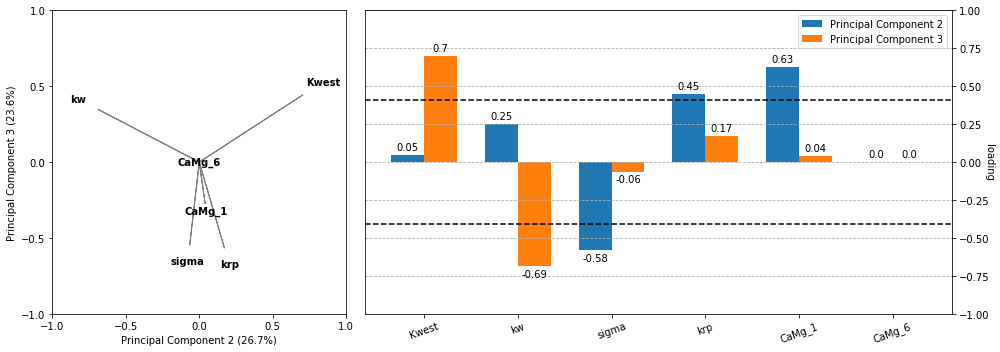

In [36]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14,5), gridspec_kw={'width_ratios':[1,2]})

# loadings plot
x_component = 2
y_component = 3

for i in range(len(stat_cols)):
    ax[0].arrow(0,0,pca.components_[x_component-1,i],pca.components_[y_component-1,i],
                color='C7')
    ax[0].text(pca.components_[x_component-1,i]*1.2,pca.components_[y_component-1,i]*1.2,stat_cols[i],
               ha='center',va='center',fontweight='bold')

ax[0].set_xlim(-1,1)
ax[0].set_xticks([-1,-0.5,0,0.5,1])
ax[0].set_ylim(-1,1)
ax[0].set_yticks([-1,-0.5,0,0.5,1])
ax[0].set_xlabel('Principal Component ' + str(x_component) + ' (' + \
                 str(np.round(pca.explained_variance_ratio_[x_component-1]*100,1)) + '%)')
ax[0].set_ylabel('Principal Component ' + str(y_component) + ' (' + \
                 str(np.round(pca.explained_variance_ratio_[y_component-1]*100,1)) + '%)')

# loadings histogram

width=0.35

rects1 = ax[1].bar(ind, eigenvectors['PC 1'], width, color='C0')
rects2 = ax[1].bar(ind + width, eigenvectors['PC 2'], width, color='C1')

ax[1].set_ylabel('loading', rotation=270)
ax[1].set_xticks(ind + width / 2)
ax[1].set_xticklabels(stat_cols, rotation=20)

ax[1].legend((rects1[0], rects2[0]), ('Principal Component '+str(x_component),
                                      'Principal Component '+str(y_component)))

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        if height>=0:
            ax[1].text(rect.get_x() + rect.get_width()/2, height+0.05,
                    np.round(height,2),
                    ha='center', va='center')
        else:
            ax[1].text(rect.get_x() + rect.get_width()/2, height-0.05,
                    np.round(height,2),
                    ha='center', va='center')

autolabel(rects1)
autolabel(rects2)

ax[1].set_ylim(-1,1)
ax[1].yaxis.grid(ls='--')
ax[1].axhline(cutoff, ls='--', c='k')
ax[1].axhline(-cutoff, ls='--', c='k')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position('right')

fig.tight_layout()

plt.show(fig)

A linear regression of R$^{2}$ to the first 3 principal components:

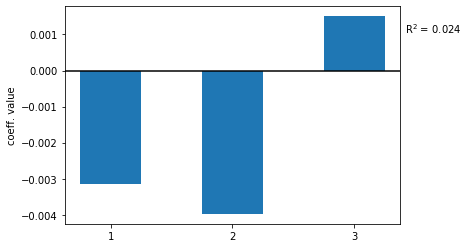

In [37]:
linreg = LinearRegression()
linreg.fit(PCA_Y[:,:3], best_filt_r2s)
score = linreg.score(PCA_Y[:,:3], best_filt_r2s)
coefs = linreg.coef_

fig, ax = plt.subplots()

index = np.arange(len(coefs))
bar_width = 0.5

ax.bar(index, coefs, bar_width)
ax.set_ylabel('coeff. value')
ax.text(1.1, 0.9, 'R$^2$ = {:.3f}'.format(score),
        horizontalalignment='center',verticalalignment='center',transform=ax.transAxes)
ax.axhline(0, c='k')

ax.set_xticks(index)
ax.set_xticklabels(index+1)

plt.show(fig)

A 3D plot:

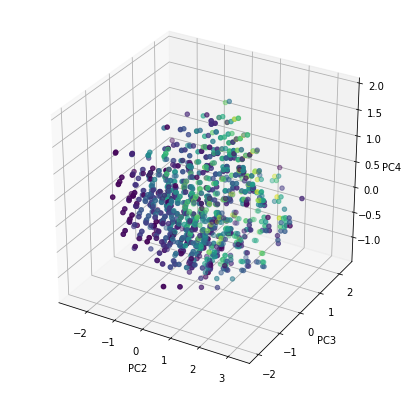

In [38]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(PCA_Y[:,2], PCA_Y[:,3], PCA_Y[:,4], c=best_filt_r2s)

ax.set_xlabel('PC2')
ax.set_ylabel('PC3')
ax.set_zlabel('PC4')

plt.show()

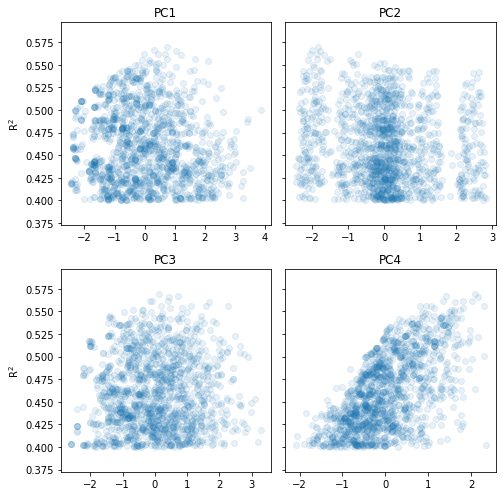

In [39]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7,7), sharey=True)

ax = ax.flatten()

alpha=0.1

ax[0].scatter(PCA_Y[:,0], best_filt_r2s, alpha=alpha)
ax[0].set_title('PC1')
ax[0].set_ylabel('R$^{2}$')

ax[1].scatter(PCA_Y[:,1], best_filt_r2s, alpha=alpha)
ax[1].set_title('PC2')

ax[2].scatter(PCA_Y[:,2], best_filt_r2s, alpha=alpha)
ax[2].set_title('PC3')
ax[2].set_ylabel('R$^{2}$')

ax[3].scatter(PCA_Y[:,3], best_filt_r2s, alpha=alpha)
ax[3].set_title('PC4')

fig.tight_layout()
plt.show(fig)